<a href="https://colab.research.google.com/github/chanseongparkk/2022_Data_Analysis_Intern_project/blob/main/%ED%95%AD%EA%B3%B5%ED%99%94%EB%AC%BC_%EC%88%98%EC%9A%94%EC%98%88%EC%B8%A1_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 데이터 접근/저장경로
# path = 'C:/Users/user/Documents/intern_project/oct_project/'  # 로컬
path = '/content/drive/MyDrive/공항공사_인턴/화물수요예측/최종/'

# 라이브러리 준비

In [ ]:
# !pip install pycaret    # autoML 모듈 설치
# !pip install pmdarima   # autoARIMA 설치
# !pip install catboost   # catboost 설치
# !pip install xgboost    # xgboost 설치
# !pip install numba --upgrade  # numba 버전 업데이트

#한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
#Runtime Menu => Restart Runtime / command+ctrl=M : 런타임 다시 시작 후 처음부터 다시 진행

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
# 필요 라이브러리 불러오기
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from dateutil import relativedelta

# plot
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# API
import requests
import json
from pprint import pprint

In [ ]:
# 모델링
import pycaret
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import ndiffs
import pmdarima as pm
import joblib
from pycaret.regression import *

In [ ]:
# mape  # 상단의 mean_absolute_percentage_error가 import 오류날 경우 실행
from sklearn.utils.validation import check_consistent_length, check_array

def mean_absolute_percentage_error(y_true, y_pred,
                                   sample_weight=None,
                                   multioutput='uniform_average'):
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
        y_true, y_pred, multioutput)
    check_consistent_length(y_true, y_pred, sample_weight)
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape,
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            # pass None as weights to np.average: uniform mean
            multioutput = None

    return np.average(output_errors, weights=multioutput)

def _check_reg_targets(y_true, y_pred, multioutput, dtype="numeric"):
    check_consistent_length(y_true, y_pred)
    y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
    y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)

    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape((-1, 1))

    if y_true.shape[1] != y_pred.shape[1]:
        raise ValueError("y_true and y_pred have different number of output "
                         "({0}!={1})".format(y_true.shape[1], y_pred.shape[1]))

    n_outputs = y_true.shape[1]
    allowed_multioutput_str = ('raw_values', 'uniform_average',
                               'variance_weighted')
    if isinstance(multioutput, str):
        if multioutput not in allowed_multioutput_str:
            raise ValueError("Allowed 'multioutput' string values are {}. "
                             "You provided multioutput={!r}".format(
                                 allowed_multioutput_str,
                                 multioutput))
    elif multioutput is not None:
        multioutput = check_array(multioutput, ensure_2d=False)
        if n_outputs == 1:
            raise ValueError("Custom weights are useful only in "
                             "multi-output cases.")
        elif n_outputs != len(multioutput):
            raise ValueError(("There must be equally many custom weights "
                              "(%d) as outputs (%d).") %
                             (len(multioutput), n_outputs))
    y_type = 'continuous' if n_outputs == 1 else 'continuous-multioutput'

    return y_type, y_true, y_pred, multioutput

Text(0.3, 0.3, '한글')

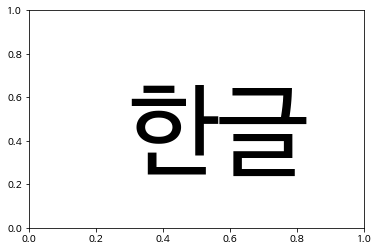

In [ ]:
# plot 한글 확인
plt.rc('font', family='NanumBarunGothic')
plt.text(0.3, 0.3, '한글', size=100)

# 데이터 준비

## 화물실적 원본 데이터(로컬)

In [ ]:
# ## 로컬에서 돌리기
# ## 원본데이터(화물실적) 로드 후 필요한 컬럼 추출
# # data = pd.read_csv(path + '화물실적(2010-2021).csv', encoding='cp949')  # 2010년 ~ 2021년 화물실적 데이터
# data = pd.read_csv(path + '화물실적(2000.01-2022.09).csv', encoding='cp949')  # 2000년 ~ 2022년 화물실적 데이터
# df = data[['일자', '운항횟수_도착', '운항횟수_출발', '화물_도착', '화물_출발', '수하물_도착', '수하물_출발', '우편물_도착', '우편물_출발']]  # 필요한 컬럼 추출
# df = df.iloc[1:,:]  # 0번째 행(영문명 컬럼) 삭제
# df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)  # 총화물량 계산을 위한 데이터형 변환

# ## 파생변수 생성
# df['총화물량'] = df['화물_도착'] + df['화물_출발'] + df['수하물_도착'] + df['수하물_출발'] + df['우편물_도착'] + df['우편물_출발']
# df['화물'] = df['화물_도착'] + df['화물_출발']
# df['수하물'] = df['수하물_도착'] + df['수하물_출발']
# df['우편물'] = df['우편물_도착'] + df['우편물_출발']
# df['운항횟수'] = df['운항횟수_도착'] + df['운항횟수_출발']
# df = df[['일자', '총화물량', '화물', '수하물', '우편물', '운항횟수']]  # 필요한 컬럼만 추출
# df['일자'] = df['일자'].astype(str)  # 추후 연산을 위한 '일자' 컬럼 데이터 형변환  # object -> string

# dfdf2 = df.groupby('일자').count()
# df2 = df.groupby(['일자']).sum()  # '일자'를 기준으로 '총화물량' 덧셈 연산
# df2['노선수'] = dfdf2['총화물량']

# df2.to_csv(path+'총화물량(2000-2022)_정리본.csv', encoding='cp949')  # 해당 데이터프레임 저장
# df2

## 공휴일 정보 - api
https://drive.google.com/open?id=1MMBjQJqozsBYoe73EerEMAMZjuedSwKX

In [ ]:
AUTH_KEY = ''   # API key

def getHolidays(year,month,key):
    url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo'

    params = {  # 요청 인자 값
        'solYear':str(year),              # 연도
        'solMonth':str(month).zfill(2),   # 월
        '_type':'json',                   # 반환 형태
        'ServiceKey' : key                # API key
    }

    res = requests.get(url,params=params)     # 데이터 요청 후 반환
    dic = json.loads(res.text)                # 반환된 데이터 로드(딕셔너리)
    counts = dic['response']['body']['totalCount']  # 필요한 부분 추출

    if counts < 1 :   # 해당 데이터 없을 경우
        return []     # 빈 리스트 return

    # 데이터 있을 경우 item에 저장
    item =  dic['response']['body']['items']['item']

    if counts == 1:
        return [item]
    return item

In [ ]:
holidays =[]

# 2004-2021 공휴일
for year in range(2000,2022):
    for month in range(1,13):
        holidays.extend(getHolidays(year,month,AUTH_KEY))

# 2022.01 ~ 2022.09 공휴일
for month in range(1,10):
    holidays.extend(getHolidays(2022,month,AUTH_KEY))

In [ ]:
# holidays

In [ ]:
df_holiday = pd.DataFrame(holidays,columns=['locdate','dateName'])    # 일자, 공휴일 정보 저장
df_holiday.to_csv(path+"공휴일.csv", index = False)
df_holiday

# 분석 모델링

In [ ]:
##### 1단계 일단위 데이터 정리

## 동일 공휴일 이름 통일
def clean_holi(holi, ex_holi, fm_holi):
    holi.loc[holi['공휴일'] == ex_holi, '공휴일'] = fm_holi
    return


## 주말(토,일요일) 여부 확인 함수
def check_day(date_today):
    year = round(date_today / 10000)
    mon = round((date_today % 10000) / 100)
    day = date_today % 100
    
    today_w = datetime(year, mon, day).weekday()  # 일자 입력 -> 요일(숫자) 반환
    return today_w


## 공휴일의 주말포함여부 판단 -> '주말제외휴일'
def check_holi(tot_df, i):
    if tot_df.iloc[i,6] == 0: # 공휴일이 아닌 경우('공휴일' 컬럼 값: 0)
        pass
    else:  # 공휴일인 경우('공휴일' 컬럼 값: 1)
        if tot_df.iloc[i,14] == 0: # 주말이 아닌 공휴일('주말' 컬럼 값: 0)
            tot_df.loc[i, '주말제외휴일'] = 1
        else:  # 공휴일이면서 주말인 경우
            tot_df.loc[i, '주말동시휴일'] = 1
    return tot_df


## 일자별 '주말제외휴일', '주말동시휴일' 1일전후 여부 판단
def prev_next_holi(tot_df, holiday):
    prev_col = holiday + '1일전'  # ex: '주말제외휴일1일전'
    next_col = holiday + '1일후'  # ex: '주말제외휴일1일후'

    # 새로운 컬럼 생성 후 0으로 초기화  # ex: 주말제외휴일1일전' = 0
    tot_df[prev_col] = 0
    tot_df[next_col] = 0
    
    tot_df.loc[tot_df[holiday]!=0, prev_col] = 1  # 휴일이면, 해당 로우의 '~1일전' 값을 1로 설정
    tot_df.loc[tot_df[holiday]!=0, next_col] = 1
    tot_df[prev_col] = tot_df[prev_col].shift(-1)  # 해당 휴일의 1일 전 '~1일전' 컬럼 값: 1
    tot_df[next_col] = tot_df[next_col].shift(1)  # 해당 휴일의 1일 후 '~1일후' 컬럼 값: 1
    tot_df.fillna(0, inplace=True)	# 결측값 0으로 대체
    return


## 일자별 기본 데이터 전처리
def return_daily_df():
    #####################################################################################
    ## 공휴일 데이터 로드
    holi = pd.read_csv(path+'/데이터_최종/공휴일_2010.csv')  # 기간 변경 시 파일명 수정!!!
    holi.columns=['일자', '공휴일']  # 필요한 컬럼 추출
    holi = holi.drop_duplicates('일자')  # 여러 휴일이 겹치는 일자는 행 하나만 남김

    # 똑같은 공휴일인데 이름이 다른 휴일들 이름 통일
    clean_holi(holi, '1월1일', '신정')  # '1월1일' -> '신정'
    clean_holi(holi, '어린이 날', '어린이날')
    clean_holi(holi, '부처님오신날', '석가탄신일')
    clean_holi(holi, '제21대 국회의원선거', '국회의원선거')
    clean_holi(holi, '국회의원선거일', '국회의원선거')
    clean_holi(holi, '대통령선거일', '대통령선거')
    clean_holi(holi, '동시지방선거일', '동시지방선거')
    holi['공휴일여부'] = 1  # 공휴일인 경우: 1, 아닌 경우: NaN


    #####################################################################################
    ## 화물량 데이터 로드 -> 기간 수정 시 파일명 수정
    # df = pd.read_csv(path+'총화물량(2010-2021)_정리본.csv', encoding='cp949', low_memory=False)
    df = pd.read_csv(path+'/데이터_최종/총화물량(2000-2022)_정리본.csv', encoding='cp949', low_memory=False)

    df = df[['일자', '화물', '운항횟수', '노선수']]  # '화물량' 기준
    df = df[df['일자'] >= 20100101]  # 공휴일 데이터와 일자 범위 맞추기##################
    df.rename(columns={'화물': '총화물량'}, inplace=True)  # 컬럼명 변경: 화물 -> 총화물량

    # 공휴일 데이터프레임, 화물 데이터프레임 결합
    holi_df = pd.merge(df, holi, how='left', on='일자')
    holi_df = holi_df.fillna(0)  # '공휴일여부' 컬럼 - 공휴일인 경우: 1, 아닌 경우: 0

    ## 일자별 요일 추출
    # '월요일' ~ '일요일' -> '0' ~ '6'
    holi_df['요일'] = holi_df['일자'].apply(lambda x: check_day(x))

    ## 요일 기준 가변수화
    day_df = pd.get_dummies(holi_df['요일'])
    day_df.columns = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

    # 요일 데이터프레임, 화물량 + 공휴일 데이터프레임 결합 후 컬럼 정리
    tot_df1 = pd.concat([holi_df, day_df], axis=1)
    tot_df1['주말'] = day_df[['토요일', '일요일']].sum(axis=1)  # 토요일 or 일요일 -> '주말': 1
    tot_df1 = tot_df1.drop(columns='요일')  # '요일' 컬럼 삭제
    tot_df = tot_df1.reset_index(drop=False)  # 'index' 컬럼 생성
    tot_df.to_csv(path+'/데이터_최종/일별_공휴일추가_정리본.csv', encoding='cp949')  # 데이터프레임 저장

    ## 주말과 휴일의 동시성 여부 판단
    tot_df['주말제외휴일'] = 0  # 주말이 아닌 휴일
    tot_df['주말동시휴일'] = 0  # 주말이면서 휴일
    
    # '주말제외휴일', '주말동시휴일' 여부 판단
    for i in range(len(tot_df)):
        tot_df = check_holi(tot_df, i)
    tot_df = tot_df.drop('index', axis=1)  # 'index' 컬럼 삭제
    
    ## 휴일 1일전후 여부 판단
    for i in ['주말제외휴일', '주말동시휴일']:
        prev_next_holi(tot_df, i)
    tot_df.to_csv(path+'/데이터_최종/일별_최종_정리본.csv', encoding='cp949')  # 데이터프레임 저장
    
    return tot_df

In [ ]:
##### 1단계 주단위 데이터 정리

## 공휴일 포함주 1주전후 여부 판단
def before_after_holi(dataframe, holiday):
    before_col = holiday + '1주전'  # ex: '기독탄신일1주전'
    after_col = holiday + '1주후'  # ex: '기독탄신일1주후'
    
    ex_cols = dataframe.columns.tolist()  # 데이터프레임 기존 컬럼 리스트
    if (before_col in ex_cols) or (after_col in ex_cols):  # 이미 만들어진 컬럼인 경우 다시 만들지 않음
        return

    # 새로운 컬럼 생성 후 0으로 초기화
    dataframe[before_col] = 0  # ex: '주말제외휴일1주전' = 0
    dataframe[after_col] = 0  # ex: '주말제외휴일1주후' = 0

    dataframe.loc[dataframe[holiday]!=0, before_col] = 1  # 휴일이면, 해당 로우의 '~1주전' 값을 1로 설정
    dataframe.loc[dataframe[holiday]!=0, after_col] = 1
    dataframe[before_col] = dataframe[before_col].shift(-1)  # 해당 휴일의 1주 전 '~1주전' 컬럼 값: 1
    dataframe[after_col] = dataframe[after_col].shift(1)  # 해당 휴일의 1주 후 '~1주후' 컬럼 값: 1
    dataframe.fillna(0, inplace=True)
    return


# 월, 계절 정보 컬럼 생성
def plus_mon_season(df):
    df['월'] = [f"{df.index.month.values[i]}월" for i in range(df.shape[0])]
    df['계절'] = 0
    df.loc[(df.월 == '12월') | (df.월 == '1월') | (df.월 == '2월'),"계절"] = "겨울"
    df.loc[(df.월 == '3월') | (df.월 == '4월') | (df.월 == '5월'),"계절"] = "봄"
    df.loc[(df.월 == '6월') | (df.월 == '7월') | (df.월 == '8월'),"계절"] = "여름"
    df.loc[(df.월 == '9월') | (df.월 == '10월') | (df.월 == '11월'),"계절"] = "가을"
    return df


## 일자별 데이터 -> 주단위 데이터 전처리
def return_monthly_df():
    # 각 공휴일별 여부 컬럼 추가
    df = return_daily_df()  # 일단위 기본 데이터 생성
    p = pd.get_dummies(df['공휴일'])  # '공휴일' 기준 가변수화
    p = p.drop(0, axis=1)
    df_w = pd.concat([df, p], axis=1)  # 일자별 기본데이터에 결합
    
    df_w = df_w.drop(['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일', '주말'], axis=1)  # 월요일 ~ 일요일, 주말 컬럼 제외
    df_w = df_w.drop(['주말동시휴일1일전', '주말동시휴일1일후',  '주말제외휴일1일전', '주말제외휴일1일후'], axis=1)
    df_w.reset_index(drop=True)  # 인덱스 재설정

    # '일자' 컬럼 데이터 형변환: object -> datetime
    df_w['일자'] = df_w['일자'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    df_w.set_index(df_w['일자'], inplace=True)  # '일자'를 인덱스로 설정
    #####################################################################################
    df_w = df_w.loc['20100103':, :]  # 일자 '20100103' ~ '20220930' 추출 -> 날짜 수정!!!

    # 일주일 단위로 묶어서 '일' -> '주' 단위 변환
    # '일요일 ~ 토요일'을 한 주로 계산
    # ex: '2010-01-09' -> (2010-01-03 ~ 2010-01-09)
    week_df = df_w.resample('W-Sat').sum()  # '공휴일' 컬럼 삭제됨
    week_df = week_df.set_index(week_df.index - pd.Timedelta(days=6))  # 시작일
    week_df = plus_mon_season(week_df)
    week_df.to_csv(path+'/데이터_최종/week_df_정리본.csv', encoding='cp949')  # 데이터프레임 저장
    
    # 공휴일별 1주전후 여부 판단
    for i in week_df.columns[4:24]:  # '주말제외휴일' ~ '현충일'
        before_after_holi(week_df, i)
    week_df.to_csv(path+'/데이터_최종/주단위_컬럼정리_정리본.csv', encoding='cp949')  # 데이터프레임 저장

    return week_df

In [ ]:
#### 2단계 주단위 ARIMA 예측

## 기간별 예측값 도출
def forecast_one_step(model):
  fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
      , return_conf_int=True)              # 신뢰구간 출력
  return (
      fc.tolist()[0],
      np.asarray(conf_int).tolist()[0]
  )


## 주단위 ARIMA 예측(part1)
def part_autoARIMA(full_data, train, test, path, name):
  print('part_autoARIMA 시작')
  # train, test 데이터
  y_train = train
  y_test = test

  kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)  # kpss test 최적 차분값 추정
  adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6) # adf test 최적 차분값 추정
  n_diffs = max(adf_diffs, kpss_diffs) # kpss와 adf test 추정 차분값 중 높은 차분값을 사용
  
  model = pm.auto_arima(y = y_train,  # 학습 데이터
                        d = n_diffs,  # 차분 차수, ndiffs 결과!
                        start_p = 1,  # 최소 p값 설정
                        max_p = 5,    # 최대 p값 설정
                        start_q = 1,  # 최소 q값 설정
                        max_q = 5,    # 최대 q값 설정
                        m = 1,        # 계절적 차분이 필요할 때 쓸 수 있는 모수로 m=4이면 분기별, m=12면 월별, m=1이면 계절적 특징을 띠지 않는 데이터
                        seasonal = False, # 계절성 ARIMA가 아니라면 False
                        stepwise = True,  # 최적의 모수를 찾기 위해 쓰는 힌드만 - 칸다카르 알고리즘을 사용할지의 여부
                        trace=True,       # stepwise로 모델을 적합할 때마다 결과를 프린트하고 싶을 때 사용
                        )
  
  # test data 예측값 산출
  forecasts = []
  y_pred = []
  pred_upper = []
  pred_lower = []

  for new_ob in y_test.values:
      fc, conf = forecast_one_step(model)
      y_pred.append(fc)
      pred_upper.append(conf[1])
      pred_lower.append(conf[0])

      model.update(new_ob)  # 모델 업데이트

      
  # 전체 데이터 예측값 산출
  forecasts2 = []
  y_pred2 = []
  pred_upper2 = []
  pred_lower2 = []

  for new_ob in full_data.values:
      fc, conf = forecast_one_step(model)
      y_pred2.append(fc)
      pred_upper2.append(conf[1])
      pred_lower2.append(conf[0])

      model.update(new_ob)  # 모델 업데이트
  
  print("test RMSE : ",round(np.sqrt(mean_squared_error(y_test.values,y_pred)),2))    # test data 예측 RMSE
  print("total RMSE : ",round(np.sqrt(mean_squared_error(full_data.values,y_pred2)),2))      # 전체 data 예측 RMSE

  # 테스트 데이터 개수만큼 예측
  y_predict = pd.DataFrame(y_pred, index = y_test.index, columns=['Prediction'])
  y_predict2 = pd.DataFrame(y_pred2, index = full_data.index, columns=['Prediction'])

  # 그래프
  fig, axes = plt.subplots(1, 1, figsize=(15, 8))
  plt.plot(y_test, label='Test')            # 테스트 데이터
  plt.plot(y_predict, label='Prediction')   # 예측 데이터
  plt.legend()
  plt.show()

  y_predict2.to_csv(f"{path}데이터_최종/{name}.csv", encoding = "cp949")  # 전체 데이터 예측값 저장
  print('part_autoARIMA 완료')

  return y_pred, y_pred2, y_predict2

In [ ]:
#### 1
#### 2단계 주단위 ARIMA 예측

def return_pred_arima():
  print('return_pred_arima 시작')

  data = return_monthly_df()
  df = data[['총화물량']]   # 일자(인덱스), 총화물량

  y_train = df[df.index < train_upper]  # 2010-01-03 ~ 2021-08-31
  y_test = df[(df.index >= test_lower) & (df.index <= test_upper)]  # 2021-09-01 ~ 2021-09-30
  print('train:',len(y_train), 'test:',len(y_test))

  y_pred, y_pred2, y_predict2 = part_autoARIMA(full_data = df, train = y_train, test = y_test, path = path, name = f"주별_arima_pred(화물)_{test_lower}")

  data['arima_pred'] = y_predict2["Prediction"].values
  print('return_final_daily 완료')

  return data

In [ ]:
#### 2단계 3단계 autoML

def part_autoML(num, train, test, target, train_size, cat_features, num_features, loss , path, name):
  # train, test 데이터 합치기
  df = pd.concat([train,test])

  # 모델링 세팅
  reg_test = setup(data = train,            # 학습 데이터
                  target = target,          # 종속변수 설정
                  train_size = train_size,  # 학습 데이터 크기 설정
                  fold = 5,                 # 반복 횟수
                  categorical_features = cat_features,  # 범주형 변수 지정
                  numeric_features = num_features,      # 수치형 변수 지정
                  fold_shuffle = True,      # Shuffle 여부
                  session_id = 42)          # random_state 값


  # automl 모델 중 rmse가 낮은 모델을 최적의 모델로 선정
  best = compare_models(sort = loss)
  best_tune = tune_model(best)  # 최적 모델로 모델링

  # 모델로 예측값 도출
  test_pred = predict_model(best_tune, data = test.drop(columns = [target],axis =1))["Label"]  # test 데이터
  total_pred = predict_model(best_tune, data = df.drop(columns = [target],axis =1))["Label"]   # 전체 데이터

  print("test RMSE : ",round(np.sqrt(mean_squared_error(test[target],test_pred)),2))    # test data 예측 RMSE
  print("total RMSE : ",round(np.sqrt(mean_squared_error(df[target],total_pred)),2))    # 전체 data 예측 RMSE

  # test data 예측 그래프
  fig, axes = plt.subplots(1, 1, figsize=(15, 8))
  plt.plot(test[target], label='총화물량')                  # 모든 데이터  
  plt.plot(test_pred, label='총화물량 예측',color = "red")  # 예측 데이터
  plt.title(f'{name}:{test_upper}')
  plt.legend()
  plt.show()

  if num == 1:
    label = '주단위'
  else:
    label = '일단위'

  y_predict = pd.DataFrame(total_pred).rename(columns = {"Label":f"{label}예측값"})
  y_predict.to_csv(f"{path}/데이터_최종/{name}.csv", encoding = "cp949")  # 예측값 저장

  return test_pred, total_pred, y_predict, best_tune

In [ ]:
def make_final_daily():
    ## 주단위최종 -> 일단위
    print('make_final_daily 시작')
    df = pred_autoML(num=1)    ## 최종 주단위 예측값 데이터프레임
    print('2단계 pred autoML 완료')

    df = df.resample(rule='D').first().ffill()  # 주단위 -> 일단위 다운샘플링

    last_time = df.index.tolist()[-1]                                     # 마지막 행의 날짜              # ex: 2021-09-25
    this_month_fir = last_time.replace(day=1)                             # 해당 달(월) 첫날              # ex: 2021-09-01
    last_month_last = this_month_fir - timedelta(days=1)                  # 지난 달의 마지막날            # ex: 2021-08-31
    last_date = last_month_last + relativedelta.relativedelta(months=1)   # 마지막 행 날짜의 월 마지막날  # ex: 2021-09-30

    # 마지막 행 일자와 당월 마지막 일자 간 차이
    n = (last_date - last_time).days
    if n == 0:  # 마지막 행의 일자가 당월의 마지막 날인 경우
      print("마지막 날짜까지 이미 존재함")
      pass
    else:  # 마지막 행의 날짜 이후에도 당월의 일수가 남은 경우
      # (당일 날짜 이후 ~ 당월 날짜)까지 datetime 생성
      # ex: 마지막날짜(2021-09-25), 생성(2021-09-26 ~ 2021-09-30)
      add_date = pd.date_range(last_time, periods=n+1, freq='D')[1:]
      add_df = pd.DataFrame(index = add_date)

      # 마지막 행의 데이터로 복사(같은 1주에 속하므로 값이 동일함)
      for x in df.columns.tolist():
        add_df[x] = df.loc[last_time, x]    

      df = pd.concat([df, add_df])  # 주단위 데이터 일자 완성
      print("부족한 날짜 행 채움")

    df2 = pd.read_csv(path+'/데이터_최종/일별_최종_정리본.csv', encoding='cp949')  # 일단위 데이터 로드
    df2 = df2.drop_duplicates('일자')   # 공휴일이 중복되는 일자 삭제 # ex: 20171003(개천절 + 추석연휴)
    df2['일자'] = df2['일자'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
    df2 = df2.set_index('일자')  # '일자'  인덱스로 설정

    df2 = df2[(df2.index >= '2010-01-03') & (df2.index <= test_upper)]  # 전체 기간 
    df2 = df2.drop('Unnamed: 0', axis=1)
    
    # 기존 일단위 데이터프레임 + 주단위예측값, 월, 계절 컬럼
    total_df = pd.concat([df2, df], axis=1)
    total_df = plus_mon_season(total_df)
    total_df.to_csv(path+'/데이터_최종/최종일단위데이터_정리본.csv', encoding='cp949')  # 데이터프레임 저장
    print('make_final_daily 완료: 최종일단위데이터 생성 완료')

    return

In [ ]:
#### 2단계 주단위 autoML 예측
#### 3단계 일단위 autoML 예측

def pred_autoML(num=0, first=0):
  if num == 1:    ## 2단계 주단위 autoML
    print(num)
    data = return_pred_arima()   # arima 예측값 포함 주단위 데이터 생성
  else:           ## 3단계 일단위 autoML
    print(num)
    if first == 1:  # 일단위 데이터 완성하고 return
      print("기존 데이터 없음! 일단위 데이터 새로 생성 시작")
      make_final_daily()  # 최종 일단위 데이터 생성
      print("최종 일단위 데이터 생성 완료")
      return
      
    else:
      data = pd.read_csv(path+'/데이터_최종/최종일단위데이터_정리본.csv', encoding='cp949').rename(columns={'Unnamed: 0':'일자'})
      data['일자'] = data['일자'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
      data = data.set_index('일자', drop=True)
      print('기존에 완성된 일단위데이터 로드')

  ## autoML
  train = data[data.index < train_upper]  # 2010-01-03 ~ 2021-09-30
  test = data[(data.index >= test_lower) & (data.index <= test_upper)]  # 2021-09-01 ~ 2021-09-30
  target = "총화물량"
  train_size = 0.999
  loss = "rmse"   # RMSE 기준으로 최적 모델 선정

  cat_features = cat_features = [i for i in data.columns if (data[i].nunique() < 3) | (data[i].dtype == "object")]
  num_features = [i for i in data.columns if (data[i].nunique() >= 3) & ((data[i].dtype == "int64")|(data[i].dtype == "float64"))]
  num_features.remove("총화물량")

  if num == 1:  ## 2단계 주단위 autoML
    name = f"최종주단위예측량_{test_lower}"
  else: ## 3단계 일단위 autoML
    name = f"최종일단위예측량_{test_lower}"

  # Auto ML 수행
  test_pred, total_pred, y_predict, best_tune = part_autoML(num = num, train = train, test = test, target = target, train_size = train_size, cat_features = cat_features, num_features = num_features,  loss = loss, path = path, name = name)
  evaluate_model(best_tune)

  if (num != 1) & (first != 1):  ## 3단계 일단위 autoML
    joblib.dump(best_tune, f"{path}일일화물량예측모델_{test_lower}.pkl")

  return y_predict

In [ ]:
# 1년치(전체기간) 주단위/일단위 학습 데이터 생성: 주단위 arima 예측 - 주단위 autoML 예측 - 일단위로 전환

start_test_month = '2021-10-01'   # 21년 10월부터 예측 시작 -> 22년 9월까지
month_li = pd.date_range(start_test_month, periods=12, freq='MS')   # 월초 기준 1년치 리스트  # ['2021-10-01', '2021-11-01', ..., '2022-09-01']

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,141886.4165,3.536984e+10,188068.7018,0.8649,0.0987,0.0784
1,159657.7495,4.478524e+10,211625.2319,0.8467,0.1184,0.0922
2,145684.2701,4.670660e+10,216117.0978,0.8538,0.1141,0.0782
3,137615.7717,3.123401e+10,176731.4694,0.8720,0.0988,0.0796
4,127665.2872,2.767648e+10,166362.4841,0.8785,0.1010,0.0790
Mean,142501.8990,3.715443e+10,191780.9970,0.8632,0.1062,0.0815
Std,10476.9156,7.450382e+09,19351.5357,0.0116,0.0084,0.0054


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 3
INFO:logs:<catboost.core.CatBoostRegressor object at 0x7f55571108d0>
INFO:logs:tune_model() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=<catboost.core.CatBoostRegressor object at 0x7f55571108d0>, probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=<catboost.core.CatBoostRegressor object at 0x7f55571108d0>, probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions


test RMSE :  239293.93
test MAPE :  0.201
total RMSE :  127989.54
total MAPE :  0.056


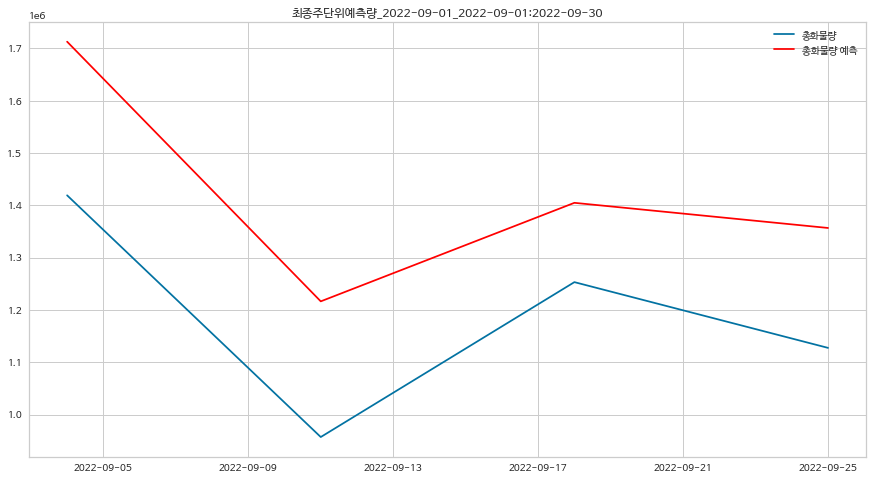

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=<catboost.core.CatBoostRegressor object at 0x7f55571108d0>, fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

2단계 pred autoML 완료
부족한 날짜 행 채움
make_final_daily 완료: 최종일단위데이터 생성 완료
최종 일단위 데이터 생성 완료


In [ ]:
last_month = month_li[-1]                      # 2022-09-01
train_upper = last_month - timedelta(days=1)   # train: 2010-01-04 ~ 2022-08-31
test_lower = last_month                        # test: 2022-09-01 ~ 2022-09-30
test_upper = last_month + relativedelta.relativedelta(months=1) - timedelta(days=1)  # 예측 종료일

train_upper = str(train_upper)[:10]
test_lower = str(test_lower)[:10]
test_upper = str(test_upper)[:10]
print(train_upper, test_lower, test_upper)

pred_autoML(first=1)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,29295.8379,1.618990e+09,40236.6786,0.8507,0.1992,0.1383
1,29434.3832,1.693121e+09,41147.5456,0.8546,0.3425,0.1850
2,30659.9440,1.847444e+09,42981.9088,0.8294,0.3275,0.2781
3,28827.0766,1.541283e+09,39259.1792,0.8504,0.2474,0.1843
4,29408.4892,1.597474e+09,39968.4155,0.8567,0.2055,0.1531
Mean,29525.1462,1.659663e+09,40718.7456,0.8484,0.2644,0.1878
Std,608.1934,1.057514e+08,1283.0819,0.0097,0.0601,0.0486


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 3
INFO:logs:<catboost.core.CatBoostRegressor object at 0x7f55555e55d0>
INFO:logs:tune_model() succesfully completed......................................
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=<catboost.core.CatBoostRegressor object at 0x7f55555e55d0>, probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor
INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=<catboost.core.CatBoostRegressor object at 0x7f55555e55d0>, probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions


test RMSE :  71396.92
test MAPE :  0.941
total RMSE :  38247.67
total MAPE :  0.164


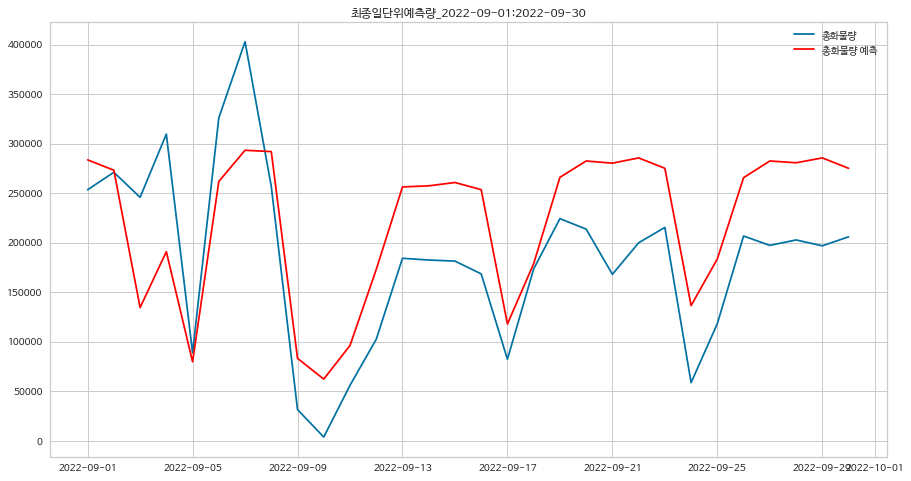

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=<catboost.core.CatBoostRegressor object at 0x7f55555e55d0>, fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

30
2022-09-01 : 2022-09-30
365
2022-09-01 00:00:00 예측 완료!


In [ ]:
## 1년치 예측
## 월마다 모델 다르게(학습 단위 diff)

year_pred_df = pd.DataFrame(columns=['일단위예측값'])

for i in month_li:
  print("===============================================================================================")

  train_upper = i - timedelta(days=1)   # 2010-01-04 ~ 예측시작 전달 말일까지 train
  test_lower = i    # 예측 시작일
  test_upper = i + relativedelta.relativedelta(months=1) - timedelta(days=1)  # 예측 종료일
  train_upper = str(train_upper)[:10]
  test_lower = str(test_lower)[:10]
  test_upper = str(test_upper)[:10]
  print("train: 2010-01-04 ~", train_upper)
  print("test:", test_lower, "~", test_upper)

  y_predict_df = pred_autoML()
  y_predict_df = y_predict_df[(y_predict_df.index >= test_lower) & (y_predict_df.index <= test_upper)]
  year_pred_df = pd.concat([year_pred_df, y_predict_df])

  print(len(y_predict_df))
  print(test_lower,":",test_upper)
  print(len(year_pred_df))
  print(i,"예측 완료!")
  print("===============================================================================================")


In [ ]:
year_pred_df.to_csv(path+"일년치_최종예측값.csv", encoding='cp949')

# 결과

In [ ]:
# 각 모델별 RMSE, MAPE 값
test_rmse_li = [18981.53, 26078.45, 23343.32, 37384.5, 51988.32, 29893.74, 11991.89, 14461.5, 17437.38, 11601.94, 24047.47, 71396.92]
total_rmse_li = [38290.51, 38478.99, 38375.15, 38245.34, 38378.19, 38254.42, 38181.58, 38271.3, 37750.47, 37786.78, 37896.53, 38247.67]
x1 = ['21.10', '21.11', '21.12', '22.1','22.2','22.3','22.4', '22.5','22.6','22.7','22.8','22.9']
y1 = test_rmse_li
y2 = total_rmse_li

In [ ]:
print("test RMSE 평균:", np.mean(test_rmse_li))
print("total RMSE 평균:", np.mean(total_rmse_li))

test RMSE 평균: 28217.24666666667
total RMSE 평균: 38179.744166666664


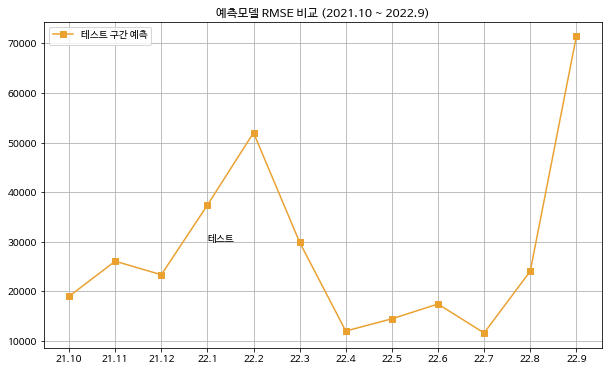

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('예측모델 RMSE 비교 (2021.10 ~ 2022.9)')
plt.plot(x1, y1, label='테스트 구간 예측', marker='s', color='#EAA130')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

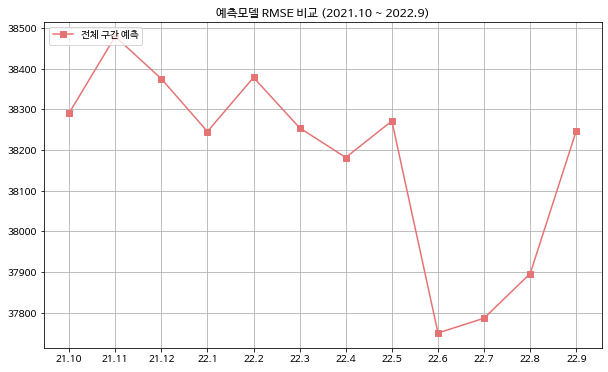

In [ ]:
plt.figure(figsize=(10,6))
plt.title('예측모델 RMSE 비교 (2021.10 ~ 2022.9)')
plt.plot(x1, y2, label='전체 구간 예측', marker='s', color='#E57373')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
year_pred = pd.read_csv(path+"/데이터_최종/일년치_최종예측값.csv", encoding='cp949').rename(columns={'Unnamed: 0':'일자'})
year_pred['일자'] = year_pred['일자'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
year_pred = year_pred.set_index('일자', drop=True)
year_pred

,일단위예측값
일자,
2021-10-01,224460.399102
2021-10-02,97703.757059
2021-10-03,121764.658715
2021-10-04,175198.097356
2021-10-05,208186.694114
...,...
2022-09-26,265606.898679
2022-09-27,282450.905946
2022-09-28,280635.831930


In [ ]:
tt = pd.read_csv(path+'/데이터_최종/최종일단위데이터_정리본.csv', encoding='cp949').rename(columns={'Unnamed: 0':'일자'})
tt['일자'] = tt['일자'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))
tt = tt.set_index('일자', drop=True)
x = tt[(tt.index >= '2021-10-01') & (tt.index <= '2022-09-30')]['총화물량']
x

일자
2021-10-01    190007.0
2021-10-02     82074.0
2021-10-03    115340.0
2021-10-04    168181.0
2021-10-05    210523.0
                ...   
2022-09-26    206704.0
2022-09-27    197240.0
2022-09-28    202744.0
2022-09-29    196823.0
2022-09-30    205855.0
Name: 총화물량, Length: 365, dtype: float64

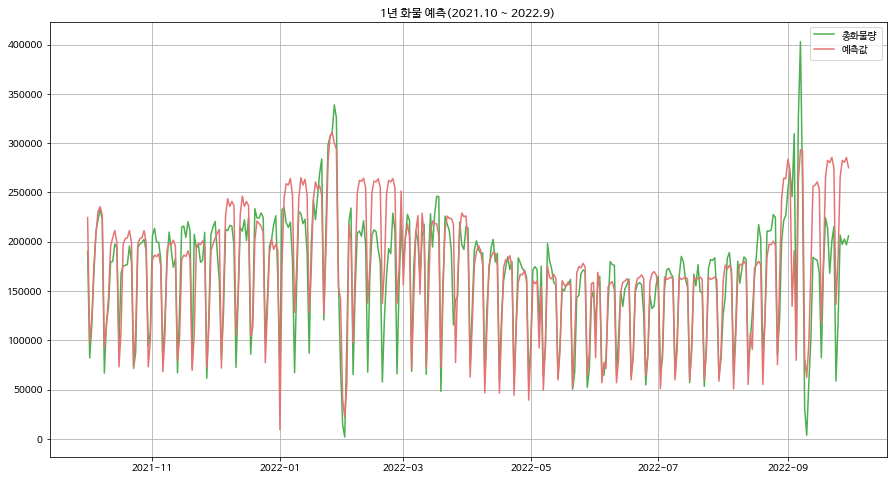

In [ ]:
plt.figure(figsize=(15, 8))
plt.title('1년 화물 예측(2021.10 ~ 2022.9)')
plt.plot(x, label='총화물량', color='#4CAF50')
plt.plot(year_pred, label='예측값', color='#E57373')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("test RMSE : ",round(np.sqrt(mean_squared_error(x,year_pred.values)), 2))    # test data 예측 RMSE

test RMSE :  32692.62
test MAPE :  0.24
test SMAPE :  0.228


# 화물 데이터 EDA

In [ ]:
df = pd.read_csv(f"{path}데이터_최종/주단위_컬럼정리_정리본.csv",encoding = "cp949")[["일자","총화물량"]]
df["일자"]= df["일자"].apply(lambda x: pd.to_datetime(x)) # 일자 datetime 형태로 변경
df = df.set_index("일자") # 날짜 형태로 되어있는 일자 변수를 인덱스로 설정
df

,총화물량
일자,
2010-01-03,2453515.0
2010-01-10,2338951.0
2010-01-17,2350311.0
2010-01-24,2820431.0
2010-01-31,3280586.0
...,...
2022-08-28,1539567.0
2022-09-04,1419209.0
2022-09-11,957203.0


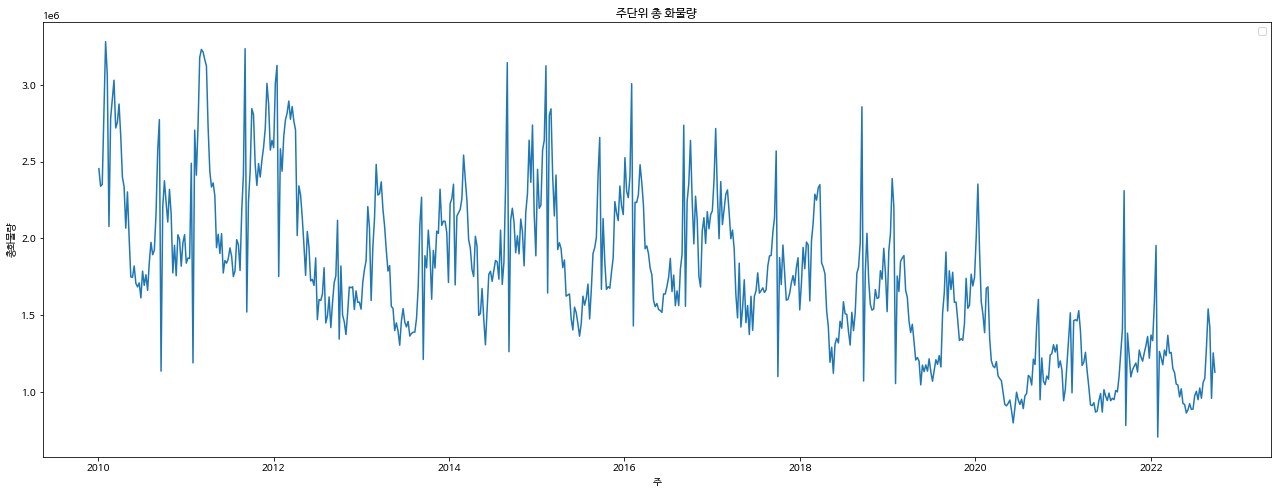

In [ ]:
# 주별 화물량 시각화 x : 일자, y : 총화물량

plt.figure(figsize = (22,8))
plt.plot(df)
plt.title("주단위 총 화물량")
plt.xlabel("주")
plt.ylabel("총화물량")
plt.show()

<Figure size 432x288 with 0 Axes>

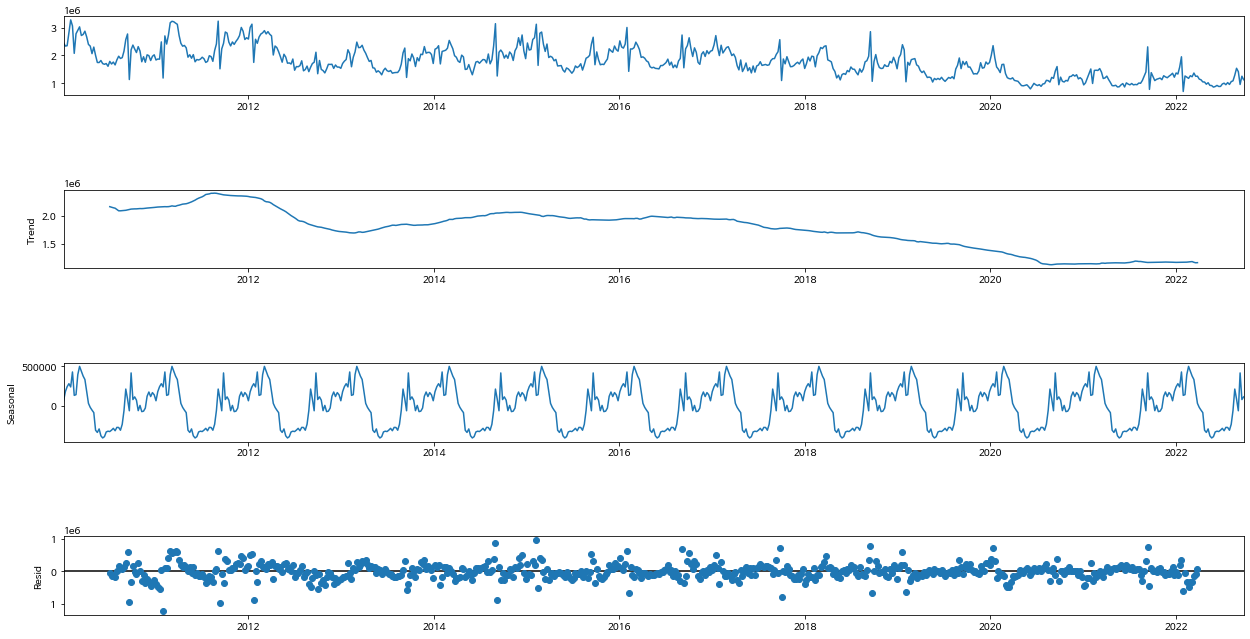

In [ ]:
# 시계열 분해
# 그림1 : 시계열 그래프, 그림2: 추세 그래프, 그림3: 계절성 그래프, 그림4: 잔차 그래프
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model = "additive")

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20,10)

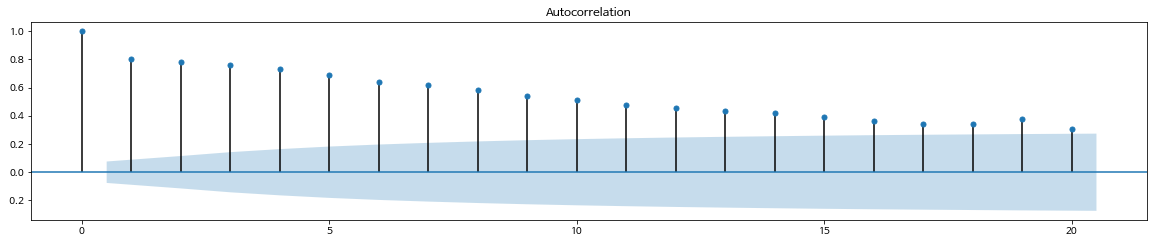

In [ ]:
# ACF 그래프
import statsmodels.api as sm
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df,lags = 20, ax = ax1)

# ACF 그래프를 보면 0에 가까운 절단값이 보이지 않기 때문에 정상성 검정을 해본다,

In [ ]:
# ADF 검정(단위근 검정)
# H0: 자료에 단위근이 존재한다. 즉 정상성을 만족하지 않는다
# H1: 정상성을 만족한다.

from statsmodels.tsa.stattools import adfuller

result = adfuller(df)

print(f"ADF Statistic : {result[0]}")
print(f"P_value : : {result[1]}")
print(f"Critical Values :")
for key, value in result[4].items():
  print("\t%s: %.3f" % (key, value))

ADF Statistic : -2.7870459186382464
P_value : : 0.06014812417561794
Critical Values :
	1%: -3.441
	5%: -2.866
	10%: -2.569


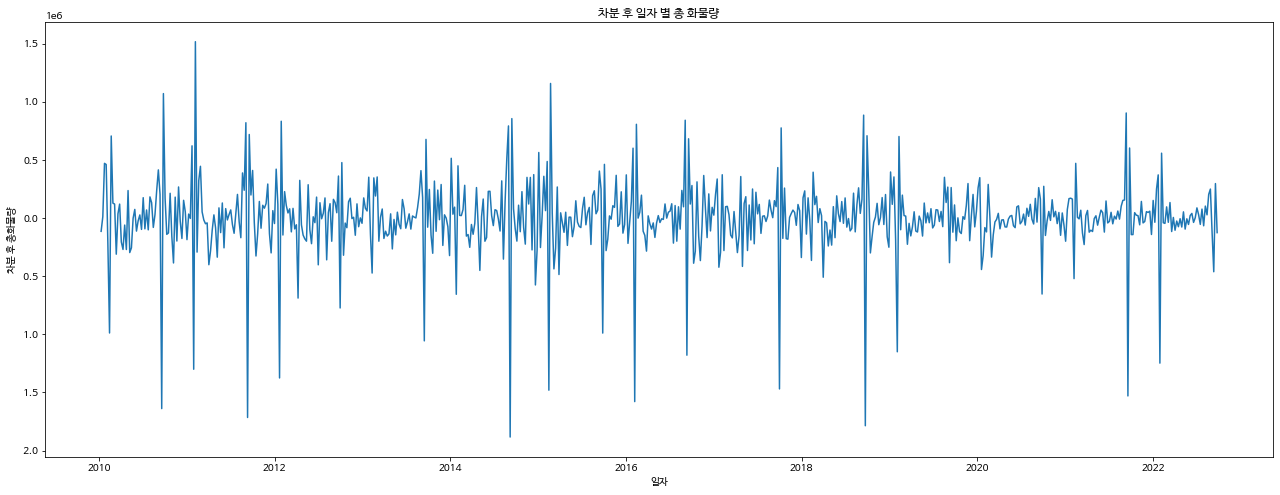

In [ ]:
# 1회 차분
ts_diff = df - df.shift()
plt.figure(figsize = (22,8))
plt.plot(ts_diff)
plt.title("차분 후 일자 별 총 화물량")
plt.xlabel("일자")
plt.ylabel("차분 후 총화물량")
plt.show()

In [ ]:
# ADF 검정(단위근 검정)
# H0: 자료에 단위근이 존재한다. 즉 정상성을 만족하지 않는다
# H1: 정상성을 만족한다.

from statsmodels.tsa.stattools import adfuller

result = adfuller(ts_diff[1:])

print(f"ADF Statistic : {result[0]}")
print(f"P_value : : {result[1]}")
print(f"Critical Values :")
for key, value in result[4].items():
  print("\t%s: %.3f" % (key, value))

ADF Statistic : -8.154459523225928
P_value : : 9.502109838388255e-13
Critical Values :
	1%: -3.441
	5%: -2.866
	10%: -2.569


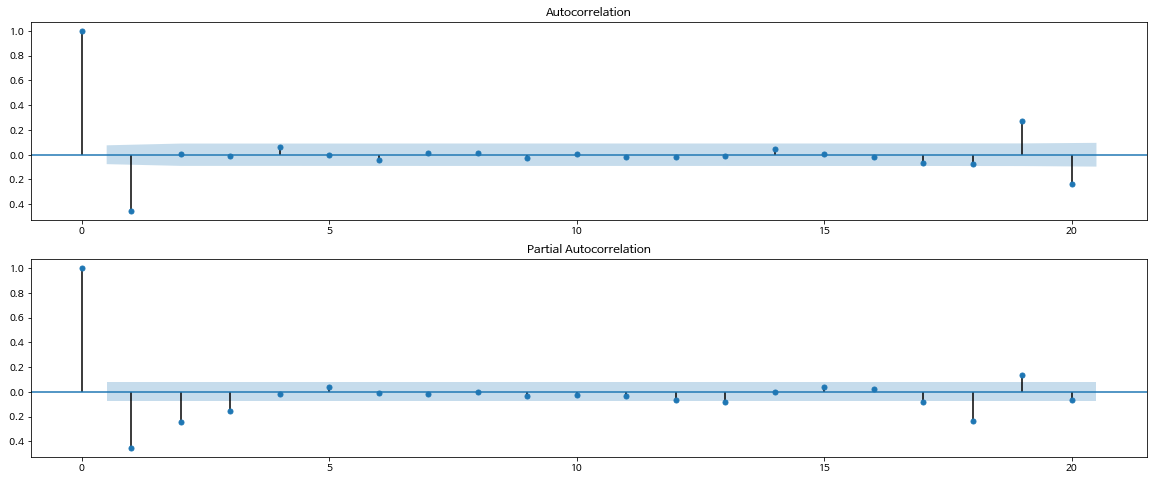

In [ ]:
# ACF 그래프
import statsmodels.api as sm
fig = plt.figure(figsize = (20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff[1:],lags = 20, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff[1:],lags = 20, ax = ax2)